In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt                                                       
from matplotlib import cm
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import ezgal # BC03 model maker
import os
from astropy.cosmology import LambdaCDM

In [2]:
# check to make sure we have defined the bpz filter path
if not os.getenv('EZGAL_FILTERS'):
    os.environ['EZGAL_FILTERS'] = (f'{os.environ["HOME"]}/Projects/planckClusters/MOSAICpipe/bpz-1.99.3/FILTER/')

In [3]:
def setup_models(zf, tau):
    #model = ezgal.model('bc03_exp_0.1_z_0.02_salp.model')
    model = ezgal.model('bc03_ssp_z_0.02_chab.model')

    if isinstance(tau, list):
        raise ValueError('tau cannot be a list')
    exp = model.make_exponential(tau)

    # set cosmology
    exp.set_cosmology(Om=0.3, Ol=0.7, h=0.7, w=-1)
    # set the model normalization to Dai et al 2009 (ApJ, 697, 506)
    exp.set_normalization('ch1', 0.24, -25.06, vega=True)
    exp.add_filter('g_MOSAICII.res', name='g')
    exp.add_filter('r_MOSAICII.res', name='r')
    exp.add_filter('i_MOSAICII.res', name='i')
    exp.add_filter('z_MOSAICII.res', name='z')
    exp.add_filter('K_KittPeak.res', name='K')
    exp.set_zfs(zf)

    return exp

In [4]:
model = setup_models(5, 1)

/home/boada/.local/lib/python3.6/site-packages/ezgal/data/models/bc03_ssp_z_0.02_chab.model


/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:358: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:360: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:361: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))
/home/boada/.local/lib/python3.6/site-packages/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


In [5]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=2.725)
cosmo

LambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Ode0=0.7, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

In [8]:
z = np.arange(0.01, 1.5, 0.01)

In [9]:
dlum = cosmo.luminosity_distance(z)

In [10]:
h = cosmo.H0.value/100

In [11]:
# Calculate some cosmological stuff
DM = cosmo.distmod(z)
dlum = cosmo.luminosity_distance(z)

Here we are going to normalize the output to be $M_\star$ galaxy as defined by Blanton et al 2003. Blanton 2003 says $M^r_\star - 5 log(h) = -20.44 \pm 0.01$ in the $r$ band at $z=0.1$. The rest of the bands, are listed in Table 2.

In [12]:
Mr_star = -20.44 + 5 * np.log10(h) # abs mag.
Mi_star = -21.22 - 5 * np.log10(h)
#Mi_star = -20.82

In [13]:
# set the normalization
model.set_normalization('r', 0.1, Mr_star, vega=False)

In [14]:
# now we can calculate the corresponding Mstar values in any other band.
# Remember we defined our model (above) to have a zf=5.
# Blanton is defined at z=0.1
filter = 'i'
Mstar = model.get_absolute_mags(5, filters=filter, zs=0.1)

In [15]:
mstar = (Mstar + DM.value + model.get_kcorrects(5, filters=filter, zs=z) +
      model.get_ecorrects(5, filters=filter, zs=z) -
      model.get_ecorrects(5, filters=filter, zs=0.1))

In [18]:
LBCG = 4.0
mstar_sub = mstar - 2.5 * np.log10(0.4)                                 
BCG = mstar - 2.5 * np.log10(LBCG)

<IPython.core.display.Javascript object>


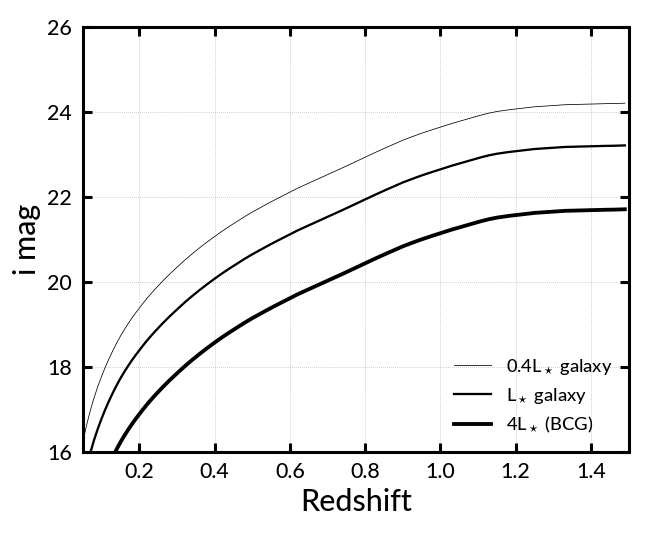

In [24]:
fig, axes = plt.subplots(1)
axes.plot(z, mstar_sub, 'k-', linewidth=0.5, label='$0.4L_\star$ galaxy')  
axes.plot(z, mstar, 'k-', linewidth=1.5, label='$L_\star$ galaxy')         
axes.plot(z, BCG, 'k-', linewidth=2.5, label='$%dL_\star$ (BCG)' % LBCG)   
axes.set_xlabel('Redshift')                                                
axes.set_ylabel(f'{filter} mag')
axes.legend(loc='lower right', fancybox=True, shadow=True)                 

axes.set_xlim(0.05, 1.5)                                                   
axes.set_ylim(16, 26)  
plt.grid()
plt.tight_layout()

In [420]:
Mi_star

-20.445490200071283

In [20]:
Mstar

-21.62029686905541

In [21]:
np.log10(1)

0.0

In [23]:
-21.22 - 5 * np.log10(h)

-20.445490200071283